In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from scipy.special import lambertw
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

# Define constants
L = 100
S_l = 1e3
d_t = 6
zeta = 2.5e3
tau = 1e4
omega = 25
kappa = 20
beta = 0.5  # Assuming beta = 0.5 as a typical value

def eta_l(l):
    """Compute eta_l based on skill level l."""
    return np.exp(7 * l / L)

def sigma_l(l):
    """Compute sigma_l based on skill level l."""
    return np.log2(l) if l > 1 else 0

def D_KL(p, q):
    """Compute KL divergence D_KL(p||q)."""
    return p * np.log(p/q) + (1-p) * np.log((1-p)/(1-q))

def g_function(R, p_rr, eta):
    """Compute g(R, p_rr, eta_l)."""
    R_choose_2 = comb(R, 2)
    # Ensure eta/R_choose_2 is within [0,1]
    eta_ratio = eta/R_choose_2
    # Ensure p_rr is within (0,1)
    p_rr_safe = p_rr
    
    return np.exp(-R_choose_2 * D_KL(eta_ratio, p_rr_safe))

def compute_p_rr(R, T, d_t):
    """Compute p_rr for a given R, T and d_t."""
    # Approximately (d_t/R)**2)*T / (S_l**2)
    return (1 - (1 - (d_t/R)**2)**T) / (S_l**2)

def compute_T(R):
    """Compute T based on R using the relationship T = (kappa * zeta) / tau * R."""
    return ((kappa * zeta) / tau) * R

def compute_p_l(R, p_rr, eta, gamma_prev, sigma):
    """Compute p_l based on the piecewise function."""
    R_choose_2 = comb(R, 2)
    
    if eta <= R_choose_2 * p_rr:
        return min(1, (1 - g_function(R, p_rr, eta)) * (gamma_prev**(2*sigma)) )
    else:
        g_val = g_function(R, p_rr, eta)
        #denominator = np.sqrt(8 * (eta) * (1 - eta/R_choose_2))
        denominator = np.sqrt(2*R_choose_2)
        return min(1, (g_val / denominator) * (gamma_prev**(2*sigma)) )


def compute_gamma_l(p_l):
    """Compute gamma_l using the Lambert W function."""
    z = -p_l * S_l * np.exp(-p_l * S_l)
    w_val = np.real(lambertw(z, k=0))
    gamma_l = 1 + (1 / (p_l * S_l)) * w_val
    # If gamma_l is nan, set it to 0
    if np.isnan(gamma_l):
        gamma_l = 0
    return gamma_l

def compute_recursive_values(R, l_max=100):
    """Compute p_l and gamma_l recursively for all levels up to l_max."""
    # Initialize with base conditions
    gamma_values = [1.0]  # gamma_0 = 1
    p_values = [0.0]      # placeholder for p_0 (not used)
    
    # Calculate T based on R
    T = compute_T(R)
    
    # Calculate p_rr
    p_rr = compute_p_rr(R, T, d_t)
    
    # Recursively compute p_l and gamma_l for each level
    for l in range(1, l_max + 1):
        gamma_prev = gamma_values[l-1]
        sigma = sigma_l(l)
        eta = eta_l(l)
        
        p_l = compute_p_l(R, p_rr, eta, gamma_prev, sigma)
        p_values.append(p_l)
        
        gamma_l = compute_gamma_l(p_l)
        gamma_values.append(gamma_l)
    
    return p_values, gamma_values

def compute_m_l_prime(l, l_prime, m):
    """Compute m_l' based on the given formula."""
    if l_prime > l:
        # Calculate the product term in the denominator
        prod = 1
        for k in range(l+1, l_prime+1):
            prod *= max(sigma_l(k), 1e-10)  # Avoid division by zero
        result = max(np.ceil(m / prod), 2)
    elif l_prime == l:
        result = m
    else:  # l_prime < l
        # Calculate the product term
        prod = 1
        for k in range(l_prime+1, l+1):
            prod *= max(sigma_l(k), 1e-10)  # Avoid division by zero
        result = np.ceil( m * prod )
    
    return result

def compute_M_l_prime(m_l_prime):
    """Compute M_l' based on m_l'."""
    return np.ceil(m_l_prime) + np.ceil(beta * m_l_prime)

def compute_training_cost(R):
    """Compute the training cost C_tr."""
    return 6 * kappa * zeta**2 * R**2

def compute_inference_cost(R, l_star, m_l_star, p_l_star):
    """Compute the inference cost C_inf."""
    M_l_star = compute_M_l_prime(m_l_star)
    
    # Avoid log(negative) issues
    product = p_l_star * M_l_star
    if product <= 1:
        return np.inf
    
    path_length = np.log(M_l_star) / np.log(product)
    return 2 * zeta * R * omega * m_l_star * path_length

def compute_accuracy(gamma_l_star, m_l_star):
    """Compute the accuracy for a given gamma_l_star and m_l_star."""
    return gamma_l_star ** m_l_star

In [133]:
def evaluate_allocation(C_tr, C_inf, l, m):
    """Evaluate accuracy for a given allocation of C_tr and C_inf."""
    # Calculate R from C_tr
    R = np.sqrt(C_tr / (6 * kappa * zeta**2))
    print("R:", R)
    
    # Find best l_star for this allocation
    best_accuracy = 0
    
    # Compute recursive values
    p_values, gamma_values = compute_recursive_values(R, l_max=L)
    
    C_inf_actual_arr = []
    # Try different l_star values
    for l_star in range(1, L+1):
        p_l_star = p_values[l_star]
        gamma_l_star = gamma_values[l_star]
        m_l_star = compute_m_l_prime(l, l_star, m)
        
        # Check if inference cost is within budget
        C_inf_actual = compute_inference_cost(R, l_star, m_l_star, p_l_star)
        C_inf_actual_arr.append(C_inf_actual)
        if C_inf_actual <= C_inf:
            # Calculate accuracy
            #accuracy = compute_accuracy(gamma_l_star, m_l_star)
            accuracy = gamma_l_star
            best_accuracy = max(best_accuracy, accuracy)
    
    plt.plot(range(1, L+1), C_inf_actual_arr)
    # Log scale
    plt.yscale('log')
    plt.title("C_inf_actual vs l_star")
    plt.xlabel("l_star")
    plt.ylabel("C_inf_actual")
    print(C_inf_actual_arr)
    return best_accuracy



R: 36514.83716701107
[16271560401194.74, 16376633498561.018, 10455461304675.533, 5319126918928.605, 2352758931720.8247, 950236600689.9086, 365969334938.44, 143661871952.29172, 64484401284.81713, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
R: 36514.83716701107
[16271560401194.74, 16376633498561.018, 10455461304675.533, 5319126918928.605, 2352758931720.8247, 950236600689.9086, 365969334938.44, 143661871952.29172, 64484401284.81713, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, 

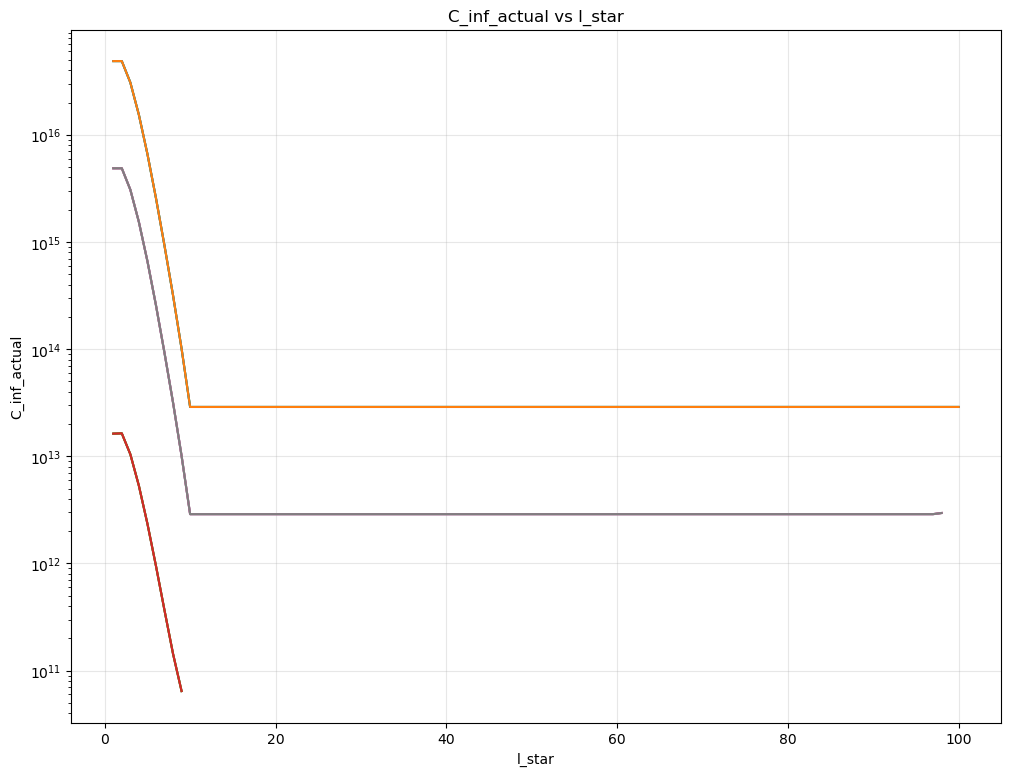

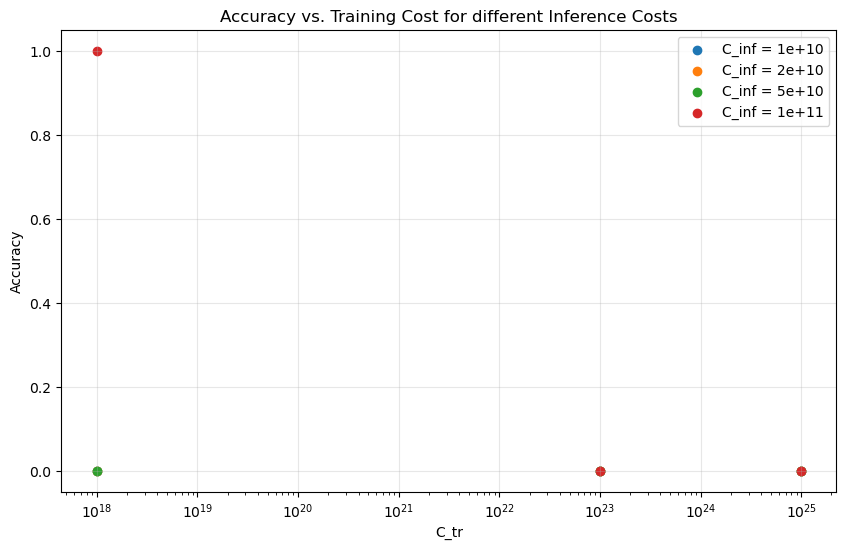

In [138]:
def create_gamma_grid(l,m,C_tr_values,C_inf_values):
    gamma_grid = np.zeros((len(C_tr_values), len(C_inf_values)))
    for i, C_tr in enumerate(C_tr_values):
        for j, C_inf in enumerate(C_inf_values):
            gamma_grid[i, j] = evaluate_allocation(C_tr, C_inf, l, m)
    return gamma_grid

def plot_gamma(gamma_grid,C_tr_values,C_inf_values):
    # Plot gamma across C_tr for different C_inf values
    plt.figure(figsize=(10, 6))
    for j, C_inf in enumerate(C_inf_values):
        plt.scatter(C_tr_values, gamma_grid[:, j], label=f'C_inf = {C_inf:.0e}')
    plt.xscale('log')
    plt.xlabel('C_tr')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs. Training Cost for different Inference Costs')
    

C_inf_values = [1e10, 2e10, 5e10, 1e11]
C_tr_values = [1e18, 1e23, 1e25]
l = 10
m = 2
gamma_grid = create_gamma_grid(l,m,C_tr_values,C_inf_values)
plot_gamma(gamma_grid,C_tr_values,C_inf_values)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         1.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         1.         1.         1.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  1.         1.         1.         1.         1.         1.
  1.         0.         0.         0.         0.         0.


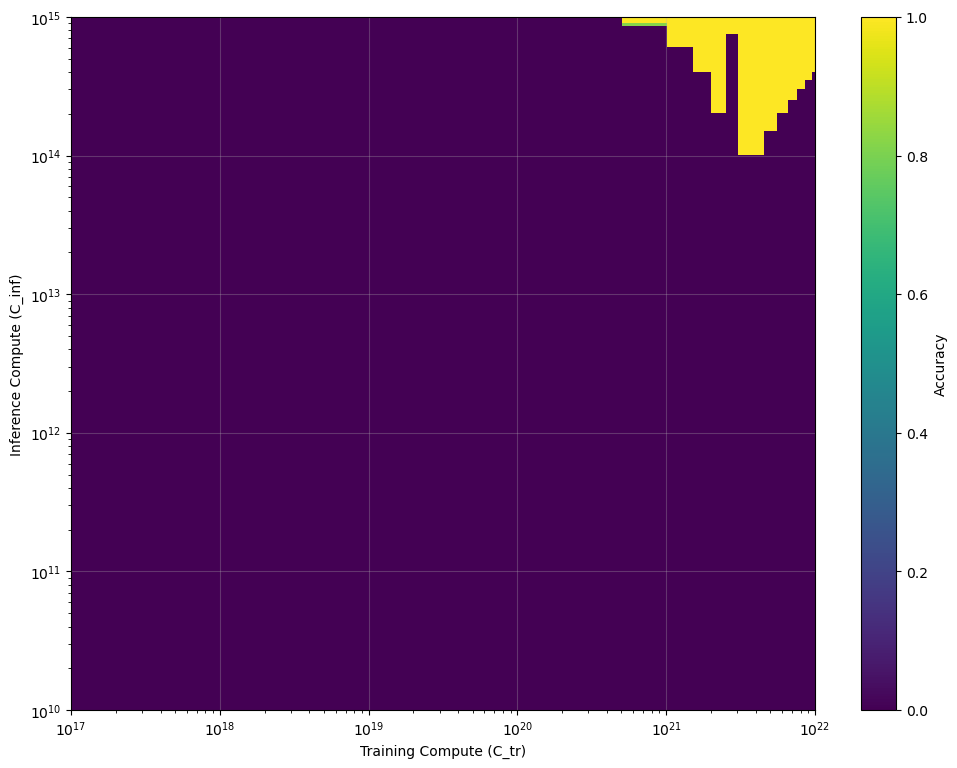

In [91]:
def create_accuracy_grid(l, m, C_tr_range, C_inf_range):
    """
    Create a 2D grid of accuracy values for ranges of C_tr and C_inf.
    
    Parameters:
    -----------
    l : int
        Skill level for the inference task
    m : int
        Number of nodes for the inference task
    C_tr_range : list
        [C_tr_min, C_tr_max] - Range of training compute values
    C_inf_range : list
        [C_inf_min, C_inf_max] - Range of inference compute values
        
    Returns:
    --------
    C_tr_grid : 2D numpy array
        Grid of C_tr values
    C_inf_grid : 2D numpy array
        Grid of C_inf values
    accuracy_grid : 2D numpy array
        Grid of accuracy values corresponding to each (C_tr, C_inf) pair
    """
    # Create 1D arrays of C_tr and C_inf values
    n_points = 20  # Number of points in each dimension
    C_tr_values = np.logspace(np.log10(C_tr_range[0]), np.log10(C_tr_range[1]), n_points)
    C_inf_values = np.logspace(np.log10(C_inf_range[0]), np.log10(C_inf_range[1]), n_points)
    
    # Create meshgrid
    C_tr_grid, C_inf_grid = np.meshgrid(C_tr_values, C_inf_values)
    accuracy_grid = np.zeros_like(C_tr_grid)
    
    # Calculate accuracy for each point in the grid
    for i in range(n_points):
        for j in range(n_points):
            C_tr = C_tr_grid[i, j]
            C_inf = C_inf_grid[i, j]
            
            # Calculate accuracy for this allocation
            accuracy_grid[i, j] = evaluate_allocation(C_tr, C_inf, l, m)
    print(accuracy_grid)
    return C_tr_grid, C_inf_grid, accuracy_grid

def plot_accuracy_grid(l, m, C_tr_range, C_inf_range):
    """
    Plot a 2D contour map of accuracy as a function of C_tr and C_inf.
    
    Parameters:
    -----------
    l : int
        Skill level for the inference task
    m : int
        Number of nodes for the inference task
    C_tr_range : list
        [C_tr_min, C_tr_max] - Range of training compute values
    C_inf_range : list
        [C_inf_min, C_inf_max] - Range of inference compute values
    """
    # Create the accuracy grid
    C_tr_grid, C_inf_grid, accuracy_grid = create_accuracy_grid(l, m, C_tr_range, C_inf_range)
    
    #plt.imshow(accuracy_grid, extent=(C_tr_range[0], C_tr_range[1], C_inf_range[0], C_inf_range[1]),
    #           aspect='auto', origin='lower', cmap='viridis')
    # Use imshow with log scale defined by C_tr_grid and C_inf_grid
    plt.imshow(accuracy_grid, extent=(C_tr_range[0], C_tr_range[1], C_inf_range[0], C_inf_range[1]),
               aspect='auto', origin='lower', cmap='viridis')
    plt.xlabel('Training Compute (C_tr)')
    plt.ylabel('Inference Compute (C_inf)')
    plt.colorbar(label='Accuracy')
    plt.xscale('log')
    plt.yscale('log')

# Define ranges for C_tr and C_inf
C_tr_range = [1e17, 1e22]  # From 10^10 to 10^13
C_inf_range = [1e10, 1e15]  # From 10^10 to 10^13

# Create and display the plot
plot_accuracy_grid(l=10, m=100, C_tr_range=C_tr_range, C_inf_range=C_inf_range)

In [ ]:
def create_accuracy_contour_plot(l, m, C_tot):
    """Create a 2D contour plot of accuracy vs. C_tr/C_tot and C_inf/C_tot ratios."""
    # Create a grid of points
    n_points = 20
    C_tr_fractions = np.linspace(0.05, 0.95, n_points)
    C_inf_fractions = np.linspace(0.05, 0.95, n_points)
    
    # Create meshgrid
    X, Y = np.meshgrid(C_tr_fractions, C_inf_fractions)
    Z = np.zeros_like(X)
    
    # Calculate accuracy for each point in the grid
    for i in range(n_points):
        for j in range(n_points):
            C_tr_fraction = X[i, j]
            C_inf_fraction = Y[i, j]
            
            # Skip invalid points where C_tr + C_inf > C_tot
            if C_tr_fraction + C_inf_fraction > 1.0:
                Z[i, j] = np.nan
                continue
            
            # Calculate C_tr and C_inf
            C_tr = C_tr_fraction * C_tot
            C_inf = C_inf_fraction * C_tot
            
            # Evaluate accuracy for this allocation
            Z[i, j] = evaluate_allocation(C_tr, C_inf, l, m)
    
    # Create the contour plot
    plt.figure(figsize=(10, 8))
    
    # Plot filled contours
    levels = np.linspace(0, np.nanmax(Z), 15)
    contour = plt.contourf(X, Y, Z, levels=levels, cmap='viridis')
    
    # Add contour lines with labels
    contour_lines = plt.contour(X, Y, Z, levels=8, colors='white', alpha=0.5)
    plt.clabel(contour_lines, inline=True, fontsize=8)
    
    # Add colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label('Accuracy')
    
    # Add constraint line (C_tr + C_inf = C_tot)
    x = np.linspace(0, 1, 100)
    y = 1 - x
    plt.plot(x, y, 'r--', linewidth=2, label=f'C_tr + C_inf = C_tot')
    
    # Find and mark the optimal point
    best_C_tr_fraction, best_accuracy, R_opt, C_tr_opt, C_inf_opt, best_l_star = optimize_allocation(C_tot, l, m)
    best_C_inf_fraction = C_inf_opt / C_tot
    
    plt.scatter([best_C_tr_fraction], [best_C_inf_fraction], color='red', s=100, marker='*')
    plt.annotate(f'Optimal: Acc={best_accuracy:.4f}\nR={R_opt:.1f}, l*={best_l_star}', 
                 xy=(best_C_tr_fraction, best_C_inf_fraction), 
                 xytext=(best_C_tr_fraction+0.1, best_C_inf_fraction-0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=6),
                 fontsize=10)
    
    # Set labels and title
    plt.xlabel('C_tr / C_tot')
    plt.ylabel('C_inf / C_tot')
    plt.title(f'Accuracy Contours for Task (l={l}, m={m}) with C_tot={C_tot:.2e}')
    
    # Add legend
    plt.legend()
    
    # Set axis limits
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.tight_layout()
    
    return plt

In [ ]:



# Set matplotlib parameters without using the problematic style
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

def plot_optimal_ratio_vs_C_tot(l, m, C_tot_range):
    """Plot optimal C_inf/C_tr ratio as a function of total compute budget."""
    # Arrays to store results
    optimal_ratios = []
    optimal_accuracies = []
    optimal_Rs = []
    optimal_l_stars = []
    
    # Calculate optimal allocations for each C_tot
    for C_tot in C_tot_range:
        try:
            best_C_tr_fraction, best_accuracy, R_opt, C_tr_opt, C_inf_opt, best_l_star = optimize_allocation(C_tot, l, m)
            ratio = C_inf_opt / C_tr_opt
            optimal_ratios.append(ratio)
            optimal_accuracies.append(best_accuracy)
            optimal_Rs.append(R_opt)
            optimal_l_stars.append(best_l_star)
        except:
            # Skip if optimization fails
            optimal_ratios.append(np.nan)
            optimal_accuracies.append(np.nan)
            optimal_Rs.append(np.nan)
            optimal_l_stars.append(np.nan)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Plot optimal ratio
    ax1.plot(C_tot_range, optimal_ratios, 'b-', linewidth=2, marker='o')
    ax1.set_ylabel('Optimal C_inf/C_tr Ratio')
    ax1.set_title(f'Optimal C_inf/C_tr Ratio vs. C_tot for Task (l={l}, m={m})')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(True, which='both', linestyle='--', alpha=0.5)
    
    # Plot optimal accuracy
    ax2.plot(C_tot_range, optimal_accuracies, 'r-', linewidth=2, marker='o')
    ax2.set_xlabel('Total Compute Budget (C_tot)')
    ax2.set_ylabel('Optimal Accuracy')
    ax2.grid(True, which='both', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    
    # Create another figure for optimal R and l_star
    fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Plot optimal R
    ax3.plot(C_tot_range, optimal_Rs, 'g-', linewidth=2, marker='o')
    ax3.set_ylabel('Optimal R')
    ax3.set_title(f'Optimal Parameters vs. C_tot for Task (l={l}, m={m})')
    ax3.set_xscale('log')
    ax3.grid(True, which='both', linestyle='--', alpha=0.5)
    
    # Plot optimal l_star
    ax4.plot(C_tot_range, optimal_l_stars, 'm-', linewidth=2, marker='o')
    ax4.set_xlabel('Total Compute Budget (C_tot)')
    ax4.set_ylabel('Optimal l*')
    ax4.grid(True, which='both', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    
    return fig, fig2

def optimize_allocation(C_tot, l, m):
    """
    Find optimal allocation of compute budget between training and inference.
    Returns best C_tr_fraction, accuracy, R_opt, C_tr_opt, C_inf_opt and l_star.
    """
    def objective(C_tr_fraction):
        """Objective function to minimize (negative accuracy)."""
        C_tr = C_tr_fraction * C_tot
        C_inf = C_tot - C_tr
        
        # Evaluate accuracy for this allocation
        accuracy = evaluate_allocation(C_tr, C_inf, l, m)
        
        # Return negative accuracy for minimization
        return -accuracy
    
    # Find optimal C_tr fraction using grid search
    best_C_tr_fraction = 0.5
    best_accuracy = 0
    
    for C_tr_fraction in np.linspace(0.05, 0.95, 19):
        accuracy = -objective(C_tr_fraction)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_C_tr_fraction = C_tr_fraction
    
    # Refine with minimize_scalar
    result = minimize_scalar(
        objective, 
        bounds=(max(0.01, best_C_tr_fraction-0.1), min(0.99, best_C_tr_fraction+0.1)), 
        method='bounded'
    )
    
    best_C_tr_fraction = result.x
    best_accuracy = -result.fun
    
    # Calculate optimal C_tr and C_inf
    C_tr_opt = best_C_tr_fraction * C_tot
    C_inf_opt = C_tot - C_tr_opt
    
    # Calculate optimal R
    R_opt = np.sqrt(C_tr_opt / (6 * kappa * zeta**2))
    
    # Find the optimal l_star
    p_values, gamma_values = compute_recursive_values(R_opt, l_max=L)
    best_l_star = l
    best_acc = 0
    
    for l_star in range(max(1, l-10), min(L, l+10)+1):
        p_l_star = p_values[l_star]
        gamma_l_star = gamma_values[l_star]
        m_l_star = compute_m_l_prime(l, l_star, m)
        
        C_inf_actual = compute_inference_cost(R_opt, l_star, m_l_star, p_l_star)
        
        if C_inf_actual <= C_inf_opt:
            accuracy = compute_accuracy(gamma_l_star, m_l_star)
            if accuracy > best_acc:
                best_acc = accuracy
                best_l_star = l_star
    
    return best_C_tr_fraction, best_accuracy, R_opt, C_tr_opt, C_inf_opt, best_l_star

# Main execution
if __name__ == "__main__":
    # Define task parameters
    l = 50  # Skill level
    m = 20  # Number of nodes
    
    # Fixed total compute budget for contour plot
    C_tot = 1e12
    
    # Create accuracy contour plot
    contour_plot = create_accuracy_contour_plot(l, m, C_tot)
    
    # Range of C_tot values for optimal ratio plot
    C_tot_range = np.logspace(10, 14, 20)
    
    # Plot optimal ratio vs. C_tot
    ratio_plot, params_plot = plot_optimal_ratio_vs_C_tot(l, m, C_tot_range)
    
    # Print optimal allocation for the specified C_tot
    best_C_tr_fraction, best_accuracy, R_opt, C_tr_opt, C_inf_opt, best_l_star = optimize_allocation(C_tot, l, m)
    print(f"Optimal allocation for C_tot = {C_tot:.2e}:")
    print(f"R_opt = {R_opt:.2f}")
    print(f"l_star_opt = {best_l_star}")
    print(f"C_tr_opt = {C_tr_opt:.2e} ({C_tr_opt/C_tot:.2%} of C_tot)")
    print(f"C_inf_opt = {C_inf_opt:.2e} ({C_inf_opt/C_tot:.2%} of C_tot)")
    print(f"C_inf/C_tr ratio = {C_inf_opt/C_tr_opt:.4f}")
    print(f"Optimal accuracy = {best_accuracy:.6f}")
    
    plt.show()